In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from pathlib import PurePath
import cv2

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam
from keras.utils import to_categorical


In [30]:
# root path
ROOT_DIR = os.getcwd()

# the origin_imgs path
DATA_PATH = os.path.join(ROOT_DIR, "origin_imgs")
TRAIN_IMG_PATH = os.path.join(ROOT_DIR, "train_imgs")

In [9]:
# image size and channel 
IMG_HEIGHT = 28
IMG_WIDTH = 28
IMG_CHANNEL = 1

# get the origin_imgs pic path
all_img_paths = glob.glob(os.path.join(DATA_PATH, "*.PNG"))

In [29]:
# TRAIN_IMG_PATH = "C:/Ipython/Keras_practice/0.1-poker-cards-dataset/train_imgs/"

# convert the channel and size of the picture
for img_path in all_img_paths:
    filename = (PurePath(img_path).stem) # get the origin images name, ex:c01
    new_filename = filename + ".png" # change the filename
    card_img_grey = cv2.imread(img_path, 0) # grayscale
    card_img = cv2.resize(card_img_grey, (IMG_HEIGHT, IMG_WIDTH))   
    
    path = os.path.join(TRAIN_IMG_PATH, new_filename).replace("\\","/") # to Windows style path
    cv2.imwrite(path, card_img) 


In [67]:
def show_image(image_path):
    # set the image size to show
    plt.figure(figsize=(8,8))

    # generate a 3*2 subplot
    for i in range(0, 6):
        img_file = 'h0'+str(i+1)+'.PNG'
        img = cv2.imread(os.path.join(image_path, img_file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(230+1+i) # (231) -> first subplot, (232) -> second subplot
        plt.title(img_file)  
        plt.axis('off')     
        plt.imshow(img)      
    plt.show()

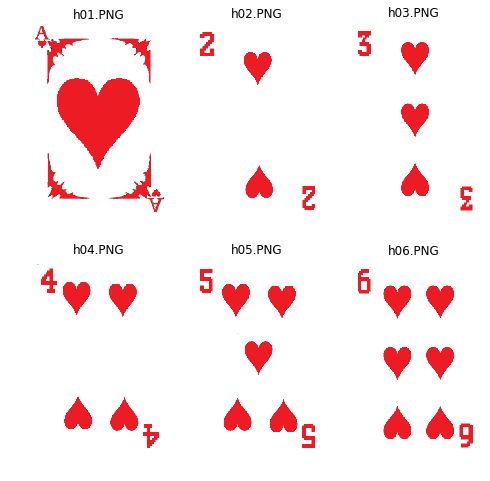

In [68]:
show_image(DATA_PATH)

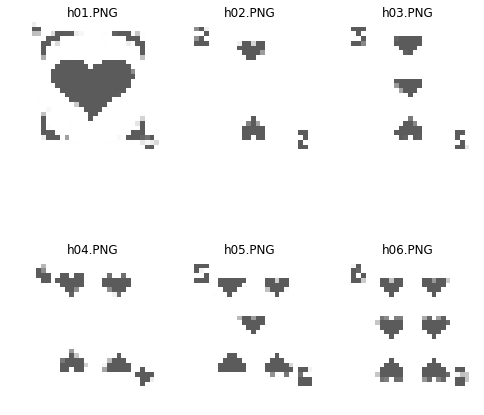

In [69]:
show_image(TRAIN_IMG_PATH)

In [91]:
num_classes = 52 
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL)
cards_data = pd.read_excel(os.path.join(ROOT_DIR, 'cards_data.xlsx'))

cards_data.head()

,image_id,image_path,card_type,card_num,card_color,card_label
0,c01,c01.png,club,1,black,club1
1,c02,c02.png,club,2,black,club2
2,c03,c03.png,club,3,black,club3
3,c04,c04.png,club,4,black,club4
4,c05,c05.png,club,5,black,club5


In [102]:
cards_label = cards_data['card_label']

# generate the dict
idx_to_label = {k:v for k, v in cards_label.iteritems()}
label_to_idx = {v:k for k, v in cards_label.iteritems()}

# get all the image label
y = np.array(cards_label.index.values)

# one-hot encoding
y_train = to_categorical(y, num_classes)
y_test = y_train.copy()

In [114]:
imgs = []
all_img_paths = glob.glob(os.path.join(TRAIN_IMG_PATH, "*.png"))

# turn type to float32 and normalization
for img_path in all_img_paths:
    img = cv2.imread(img_path,0) 
    img = img.astype('float32')/255.
    imgs.append(img)
    
X = np.array(imgs)    

# reshape to (num of image, image widthm image height, channel)
X_train = X.reshape(X.shape[0], 28, 28, 1)
X_test = X_train.copy()

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)

X_train: (52, 28, 28, 1)
y_train: (52, 52)


In [127]:
def cnn_model():
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))    
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2
                                     )))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model;   

model = cnn_model() 
model.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 26, 26, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 6, 6, 64)          0         
__________

In [129]:
lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy',
             optimizer=sgd,
             metrics=['accuracy'])

In [130]:
datagen_train = ImageDataGenerator(rotation_range=3.)
datagen_train.fit(X_train)

In [131]:
batch_size = 100
steps_per_epoch = 1000
training_epochs = 10

# 透過data generator來產生訓練資料, 由於資料是可持續產生, 我們可以透過設定'steps_per_epoch'的數量來讓模型可以有更多的訓練批次
history = model.fit_generator(datagen_train.flow(X_train, y_train, batch_size=batch_size),
                            steps_per_epoch= steps_per_epoch,
                            epochs=training_epochs)

Epoch 1/10
1000/1000 [==============================] - 18s - loss: 1.0542 - acc: 0.7213    
Epoch 2/10
1000/1000 [==============================] - 18s - loss: 0.0117 - acc: 0.9962    
Epoch 3/10
1000/1000 [==============================] - 18s - loss: 0.0032 - acc: 0.9991    
Epoch 4/10
1000/1000 [==============================] - 18s - loss: 0.0055 - acc: 0.9985    
Epoch 5/10
1000/1000 [==============================] - 18s - loss: 0.0033 - acc: 0.9990    
Epoch 6/10
1000/1000 [==============================] - 18s - loss: 0.0013 - acc: 0.9996    
Epoch 7/10
1000/1000 [==============================] - 18s - loss: 0.0012 - acc: 0.9997    
Epoch 8/10
1000/1000 [==============================] - 18s - loss: 0.0018 - acc: 0.9996    
Epoch 9/10
1000/1000 [==============================] - 18s - loss: 4.8567e-04 - acc: 0.9999    
Epoch 10/10
1000/1000 [==============================] - 18s - loss: 1.4834e-04 - acc: 1.0000    
